# Code for Functions

The project aims to use the **pseudo-spectral method** to solve the 1-dimensional **Advection-Diffusion equation**:

<font size= "3">$$\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2} - v\frac{\partial u}{\partial x}$$</font>

where $u(x,t)$ is the quantity being transported, $t$ is time, $x$ is the spatial coordinate along the one-dimensional domain, $D$ is the diffusion coefficient, and $v$ is the velocity of the flow. 

### Import all necessary modules

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from matplotlib import cm

## Functions for solving the PDE

In [6]:
# Temporal Domain
def time_domain(tmax,dt):
    '''
    This is the function used to define the time domain.
    tmax is the total time.
    dt is the time step.
    '''
    t = np.arange(0,tmax,dt)
    return t

In [2]:
# Spatial Domain
class create_grid:
    '''
    This is a class that creates the spatial grid of the PDE.
    This class will store two numpy arrays: the physical grid `x` and the Fourier grid `wavenumber`. 
    The two grids will be calculated once the class is called, and there will be no repeated calculation in later computations.
    '''
    def __init__(self, length, num_of_points):
        self.length = length
        self.num_of_points = num_of_points
    
        def create_x(self):
            '''
            This is the function to find the physical domain x.
            The input is the length of the physical domain and the number of discretisation points.
            the physical domain is centred at 0.
            '''
            dx = self.length/self.num_of_points             # step in the physical domain x
            x = np.arange(-self.length/2,self.length/2,dx)  # x is the numpy array that begin at -Length/2 and end at Length/2 - dx
            return x

        def create_wavenum(self):
            '''
            This is the function to find the Fourier domain, discrete wavenumber domain, of a given physical domain x.
            The output is the Fourier wavenumber domain, a numpy array, kappa.
            '''
            dx = self.length/self.num_of_points             # step in the physical domain x
            kappa = 2*np.pi*np.fft.fftfreq(self.num_of_points,d=dx)
            return kappa

        self.x = create_x(self)
        self.wavenum = create_wavenum(self)
        return

def test_grid(tol):
    # Test using x = [-2pi,-3pi/2,-pi,-pi/2,0,pi/2,pi,3pi/2]
    l = 4*np.pi
    n = 8
    grid = create_grid(l,n)
    
    true_x = np.array([-2*np.pi,-3*np.pi/2,-np.pi,-np.pi/2,0,np.pi/2,np.pi,3*np.pi/2])
    calc_x = grid.x
    test_phys_domain = sum(np.abs(true_x - calc_x)) < tol
    
    true_wavenum = 2*np.pi*np.array([0,1,2,3,-4,-3,-2,-1])/(8*np.pi/2)
    calc_wavenum = grid.wavenum
    test_four_domain = sum(np.abs(true_wavenum - calc_wavenum)) < tol
    
    return (test_phys_domain and test_four_domain).all()

t = 1e-12
assert test_grid(t)

In [3]:
# Derivative calculation using the pseudo-spectral method
def derivative(grid, f, order):
    '''
    This is the function for finding the derivative of a function f with domain x, using the pseudo-spectral method. 
    The function f is being transformed to the Fourier basis and then calculate the derivative by multiplying i*wave number.
    The order of derivative can be defined at the beginning as an input.
    The output is the given order derivative in the physical domain.
    '''
    κ = grid.wavenum                          # wavenumber domain for the function f
    fhat = np.fft.fft(f)                      # Fourier tranform of f
    d_ord_fhat = ((1j*κ)**order)*fhat         # the 'order'th derivative of fhat 
    d_ord_f = np.fft.ifft(d_ord_fhat).real    # the 'order'th derivative of f
      
    return d_ord_f

def test_derivative(tol):
    # Test using f = sin(2x) for x in -2pi to 2pi
    grid = create_grid(4*np.pi,100)
    x = grid.x
    f = np.sin(2*x)
    true_df = -4*f
    calc_df = derivative(grid,f,2)
    return sum(np.abs(calc_df - true_df)) < tol

t = 1e-10
assert test_derivative(t)

In [8]:
def adv_diff_eq(t,u,grid,D,v):
    '''
    This function is for deriving the advection diffusion equation with rhs fully solved.
    This function will be implemented in the later integration function.
    t is the temporal domain, which should take the form t = time_domain(tmax,dt).
    grid is the grid of spatial domain, containing the physical domain and fourier domain.
    D is the diffusion coefficient.
    v is the advection velocity.
    '''
    d_u = derivative(grid,u,1)
    dd_u = derivative(grid,u,2)
    
    du_dt = D*dd_u - v*d_u
    return du_dt

In [9]:
def burger_eq(t,u,grid,D):
    '''
    This function is for deriving the burger's equation with rhs fully solved.
    t is the temporal domain, which should take the form t = time_domain(tmax,dt).
    grid is the grid of spatial domain, containing the physical domain and fourier domain.
    D is the diffusion coefficient.
    '''
    d_u = derivative(grid,u,1)
    dd_u = derivative(grid,u,2)
    
    du_dt = D*dd_u - u*d_u
    return du_dt

In previous steps, we tried to use the pseudo-spectral method to find the derivatives with respect to x on the right-hand-side of the PDEs. At the end of the last step, we have successfully changed the PDE into an ODE with respect to time, so that the function looks like $\frac{d}{dt}u(x,t) = g(u(x,t)) $. Now, the final step of solving the PDE uses the `scipy.integrate` function `integrate.solve_ivp`. This function find the integration of an ode using the DOP853 algorithm. 

In [16]:
def gaussian_solution(t, x, σ, D): # σ is the width of the Gaussian curve initially
    return σ / np.sqrt(σ**2 + 2*D*t) * np.exp(-x**2 / (2*(σ**2 + 2*D*t)))

def analytical_sol(x,t,D,v):
    analytical_sol = np.zeros((len(x),len(t)))
    for i in range(len(t)):
        analytical_sol[:,i] = gaussian_solution(t[i],x - v*t[i],0.8,D)
    return analytical_sol

def test_solve_dudt(D,v,tol):
    # Use the Gaussian Equation to test the solutions
    grid = create_grid(10*np.pi,512)
    x = grid.x
    t = time_domain(1,0.025)    # Time domain
    
    u0 = gaussian_solution(t[0],x,0.8,D)

    
    # Numerical solution for advection equation
    numerical_sol  = integrate.solve_ivp(adv_diff_eq,[t[0],t[-1]],u0,args=(grid,D,v),t_eval=t,method='DOP853')
    numerical_sol_f = numerical_sol.y[:,-1]
    
    # Analytical solution for advection equation: u(x,t) = ui(x - v*t)
    ana_sol = analytical_sol(x,t,D,v)
    analytical_sol_f = ana_sol[:,-1]

    # # If you want to plot the final stages of the numerical and analytical solutions
    # plt.plot(x,numerical_sol_f, label='Numerical solution')
    # plt.plot(x,analytical_sol_f, label='Analytical solution')
    # plt.plot(x,numerical_sol_f - analytical_sol_f,label='error')
    # plt.legend()
    # plt.show()
    
    mean_error = np.mean(np.abs(numerical_sol_f - analytical_sol_f))
    return mean_error < tol

t = 1e-6
# Case 1: Constant advection only, no diffusion
assert test_solve_dudt(0,4,t)
# Case 2: Constant diffusion only, no advection
assert test_solve_dudt(4,0,t)

In [4]:
# Set up plotting
def plot_anim(t,grid,u0,u):
    '''
    This function is used to plot the stationary plot and animation of the wave.
    The first subplot shows the initial state and the final state of the function.
    The second subplot shows the movement of the wave with time. 
    '''
    x = grid.x
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    
    ax1.plot(x,u0,label='u at t = 0')
    ax1.plot(x,u.y[:,-1],label='u at t = $t_{final}$')
    ax1.set_title('Stationary plot for $u(x,t)$')
    ax1.set_xlabel('x')
    ax1.set_ylabel('u')
    ax1.legend(fontsize=12)

    line, = ax2.plot([],[],lw=3)
    ax2.set_xlim((x[0],x[-1]))
    ax2.set_ylim((np.min(u.y),np.max(u.y)))
    ax2.set_title('t = {:.3f}'.format(t[0])) 

    def plot_frame(i):
        line.set_data(x,u.y[:,i])
        ax2.set_title('t = {:.3f}'.format(t[i]))
        fig.canvas.draw()
        return line,

    # Animate the solution
    anim = animation.FuncAnimation(fig, plot_frame,frames=len(t),interval=80,repeat=False,blit=True)
    plt.close()
    
    return HTML(anim.to_jshtml())

## Validation and Comparison
We will test how error change with the choice of x using the Advection-diffusion equation with initial condition equals to the Gaussian function. Error is being calculated as the mean error at $t_{final}$. Three cases being tested are the advection only ($v = 0.5$), diffusion only ($D = 0.5$), and both advection and diffusion ($v = 0.5, D = 0.5$).

In [17]:
def error(num_v,D,v):
    error_array = []
    t = time_domain(10,0.1)
    
    for i in range(1,num_v):
        grid_v = create_grid(10*np.pi,2**i)
        x_v = grid_v.x
        u0_v = gaussian_solution(0,x_v,0.8,0)
        numerical_sol = integrate.solve_ivp(adv_diff_eq,[t[0],t[-1]],u0_v,args=(grid_v,D,v),t_eval=t,method='DOP853')

        numerical_f = numerical_sol.y[:,-1]
        analytical_f = analytical_sol(x_v,t,D,v)[:,-1]
    
        mean_error = np.abs(numerical_f - analytical_f).mean()
        error_array.append(mean_error)
    
    return error_array

In [18]:
error_do = error(11,0.5,0.0)
error_ao = error(11,0.0,0.5)
error_both = error(11,0.5,0.5)

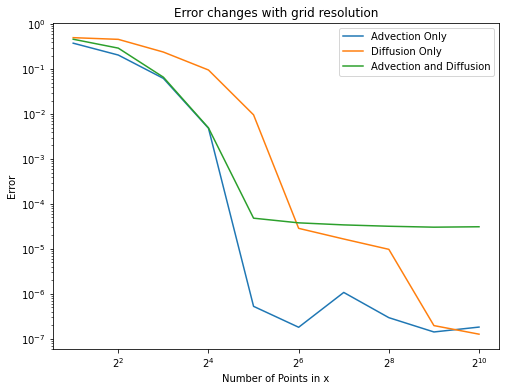

In [19]:
plt.figure(figsize = (8,6))
plt.plot(2**np.arange(1,11),error_do,label='Advection Only')
plt.plot(2**np.arange(1,11),error_ao,label='Diffusion Only')
plt.plot(2**np.arange(1,11),error_both,label='Advection and Diffusion')
plt.xscale('log',base=2)
plt.yscale('log')
plt.title('Error changes with grid resolution')
plt.xlabel('Number of Points in x')
plt.ylabel('Error')
plt.legend()
plt.show()

We found that the error generally become small enough and stable at around $2^6$ points, which is 64 points in x. This suggests that solutions generally converge quickly in terms of grid resolution, and using a small number of points can find a relatively accurate answer using the pseudo-spectral method.